# Ising MUCA

In [1]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using Random
using StatsBase
using Plots
using MonteCarloX
using SpinSystems
using MPI
using Distributed

if !MPI.Initialized()
    MPI.Init()
end
comm = MPI.COMM_WORLD
rank = MPI.Comm_rank(comm)
nprocs_mpi = MPI.Comm_size(comm)

  Activating project at `~/.julia/dev/MonteCarloX/notebooks`
Precompiling packages...
   1232.9 ms  ✓ MonteCarloX
   1682.1 ms  ✓ SpinSystems
  2 dependencies successfully precompiled in 6 seconds. 218 already precompiled.


1

## Exact Beale solution as a reference

In [2]:
L = 8
N = L * L
bins = collect((-2N - 2):4:(2N + 2))
E_axis = Int.(bins[1:end-1] .+ 2)

log_dos_beale_8x8 = [
    (-128, 0.6931471805599453), (-120, 4.852030263919617), (-116, 5.545177444479562),
    (-112, 8.449342524508063), (-108, 9.793672686528922), (-104, 11.887298863200714),
    (-100, 13.477180596840947), (-96, 15.268195474147658), (-92, 16.912371686315282),
    (-88, 18.59085846191256), (-84, 20.230089202801466), (-80, 21.870810400320693),
    (-76, 23.498562234123614), (-72, 25.114602234581373), (-68, 26.70699035290573),
    (-64, 28.266152815389898), (-60, 29.780704423363996), (-56, 31.241053997806176),
    (-52, 32.63856452513369), (-48, 33.96613536105969), (-44, 35.217576663643314),
    (-40, 36.3873411250109), (-36, 37.47007844691906), (-32, 38.46041522581422),
    (-28, 39.35282710786369), (-24, 40.141667825183845), (-20, 40.82130289691285),
    (-16, 41.38631975325592), (-12, 41.831753810069756), (-8, 42.153328313883975),
    (-4, 42.34770636939425), (0, 42.41274640460084), (4, 42.34770636939425),
    (8, 42.153328313883975), (12, 41.831753810069756), (16, 41.38631975325592),
    (20, 40.82130289691285), (24, 40.141667825183845), (28, 39.35282710786369),
    (32, 38.46041522581422), (36, 37.47007844691906), (40, 36.3873411250109),
    (44, 35.217576663643314), (48, 33.96613536105969), (52, 32.63856452513369),
    (56, 31.241053997806176), (60, 29.780704423363996), (64, 28.266152815389898),
    (68, 26.70699035290573), (72, 25.114602234581373), (76, 23.498562234123614),
    (80, 21.870810400320693), (84, 20.230089202801466), (88, 18.59085846191256),
    (92, 16.912371686315282), (96, 15.268195474147658), (100, 13.477180596840947),
    (104, 11.887298863200714), (108, 9.793672686528922), (112, 8.449342524508063),
    (116, 5.545177444479562), (120, 4.852030263919617), (128, 0.6931471805599453)
]
exact_logdos = Dict(log_dos_beale_8x8);

In [3]:
function rmse_exact(lw::TabulatedLogWeight)
    est = -Float64.(lw.table.weights)
    ref = [haskey(exact_logdos, E) ? exact_logdos[E] : NaN for E in E_axis]
    i0 = findfirst(==(0), E_axis)
    if i0 !== nothing && isfinite(ref[i0])
        est .-= est[i0]
        ref .-= ref[i0]
    end
    idx = findall(i -> isfinite(ref[i]) && isfinite(est[i]), eachindex(E_axis))
    return sqrt(mean((est[idx] .- ref[idx]).^2))
end

rmse_exact (generic function with 1 method)

## Plotting helper

In [4]:
function plot_from_hist_lw(hist_vec::Vector{Histogram}, lw_vec::Vector{TabulatedLogWeight}; title_prefix="")
    n = length(hist_vec)
    cols = palette(:viridis, max(n, 2))[1:n]

    p1 = plot(xlabel="E", ylabel="counts", title="$(title_prefix)histograms", legend=false)
    for i in 1:n
        plot!(p1, E_axis, hist_vec[i].weights; lw=2, color=cols[i])
    end

    p2 = plot(xlabel="E", ylabel="-logweight", title="$(title_prefix)weights", legend=false)
    for i in 1:n
        w = -Float64.(lw_vec[i].table.weights)
        i0 = findfirst(==(0), E_axis)
        if i0 !== nothing
            w .-= w[i0]
        end
        plot!(p2, E_axis, w; lw=2, color=cols[i])
    end
    ref_curve = [haskey(exact_logdos, E) ? exact_logdos[E] : NaN for E in E_axis]
    i0 = findfirst(==(0), E_axis)
    if i0 !== nothing && isfinite(ref_curve[i0])
        ref_curve .-= ref_curve[i0]
    end
    plot!(p2, E_axis, ref_curve; lw=2, color=:black, ls=:solid)

    rmse = [rmse_exact(lw) for lw in lw_vec]
    p3 = scatter(1:n, rmse; ms=4, color=:steelblue, xlabel="iter", ylabel="RMSE", title="$(title_prefix)RMSE", legend=false)
    display(plot(p1, p2, p3, layout=(1,3), size=(980, 260), margin=4Plots.mm))
    return rmse
end

plot_from_hist_lw (generic function with 1 method)

## Serial MUCA

In [5]:
# Serial: run + collect
n_iter = 10
sweeps_therm = 80
sweeps_record = 1000
sys = IsingLatticeOptim(L, L)
init!(sys, :random, rng=MersenneTwister(2026))
lw = TabulatedLogWeight(Histogram((collect(bins),), zeros(Float64, length(bins)-1)))
alg = Multicanonical(MersenneTwister(12_026), lw)

serial_hists = Histogram[]
serial_lws = TabulatedLogWeight[]
meas = Measurements([:energy_hist => (s -> Int(energy(s))) => fit(Histogram, Int[], bins)], interval=1)
for _ in 1:n_iter
    for _ in 1:(sweeps_therm * length(sys.spins))
        spin_flip!(sys, alg)
    end
    # reset measurement data
    reset!(meas)
    for i in 1:(sweeps_record * length(sys.spins))
        spin_flip!(sys, alg)
        measure!(meas, sys, i)
    end
    h = meas[:energy_hist].data
    update_weights!(alg, h; mode=:simple)
    push!(serial_hists, deepcopy(h))
    push!(serial_lws, deepcopy(lw))
end

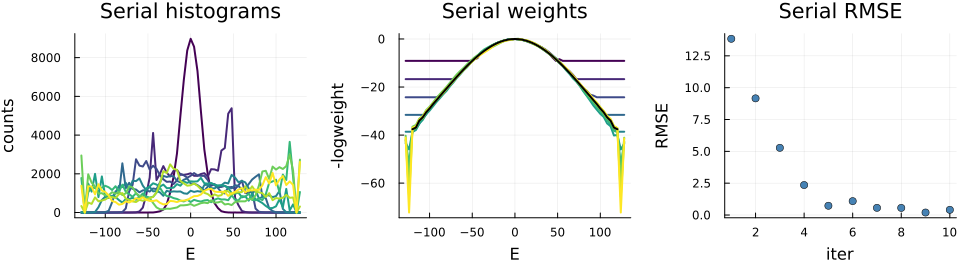

Final serial RMSE (exact) = 0.4078


In [6]:
# Serial: RMSE + plot (vs exact Beale logDOS)
rmse_serial = plot_from_hist_lw(serial_hists, serial_lws; title_prefix="Serial ")
println("Final serial RMSE (exact) = ", round(last(rmse_serial), digits=4))

## MPI Version (in notebook only 1 core)

In [7]:
# MPI: run + collect (same pattern as serial)
sys_local = IsingLatticeOptim(L, L)
init!(sys_local, :random, rng=MersenneTwister(1000 + rank))
lw_local = TabulatedLogWeight(Histogram((collect(bins),), zeros(Float64, length(bins)-1)))
rep_local = Multicanonical(MersenneTwister(2000 + rank), lw_local)
pmuca = ParallelMulticanonical([rep_local]; rank=rank, comm_size=nprocs_mpi, local_indices=[1], master_rank=0)

mpi_hists = Histogram[]
mpi_lws = TabulatedLogWeight[]
meas_local = Measurements([:energy_hist => (s -> Int(energy(s))) => fit(Histogram, Int[], bins)], interval=1)

for _ in 1:n_iter
    for _ in 1:(sweeps_therm * length(sys_local.spins))
        spin_flip!(sys_local, rep_local)
    end

    reset!(meas_local)
    for i in 1:(sweeps_record * length(sys_local.spins))
        spin_flip!(sys_local, rep_local)
        measure!(meas_local, sys_local, i)
    end
    h_local = meas_local[:energy_hist].data

    w_local = Float64.(h_local.weights)
    w_global = similar(w_local)
    MPI.Allreduce!(w_local, w_global, MPI.SUM, comm)
    h_global = deepcopy(h_local)
    h_global.weights .= w_global

    update_weights!(pmuca, [h_global]; mode=:simple, master_replica_index=1)
    MPI.Bcast!(rep_local.logweight.table.weights, 0, comm)

    push!(mpi_hists, deepcopy(h_global))
    push!(mpi_lws, deepcopy(rep_local.logweight))
    MPI.Barrier(comm)
end

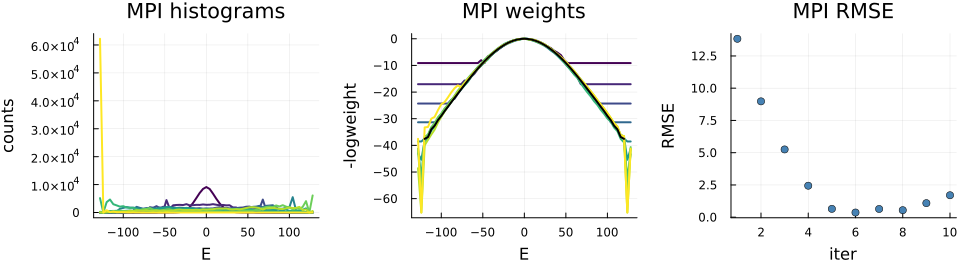

Final MPI RMSE (exact) = 1.7002


In [8]:
# MPI: RMSE + plot (vs exact Beale logDOS)
if rank == 0
    rmse_mpi = plot_from_hist_lw(mpi_hists, mpi_lws; title_prefix="MPI ")
    println("Final MPI RMSE (exact) = ", round(last(rmse_mpi), digits=4))
end

## Notebook-local MPI-style parallel MUCA
This runs multiple local replicas in one notebook process, but uses the same `ParallelMulticanonical` API as MPI.

In [9]:
# Notebook-local MPI-style run + collect (same API, no worker plumbing)
nrep_local = max(2, nprocs_mpi)
sweeps_record_local = max(1, Int(round(sweeps_record / nrep_local)))

systems_local = [IsingLatticeOptim(L, L) for _ in 1:nrep_local]
for (j, sysj) in enumerate(systems_local)
    init!(sysj, :random, rng=MersenneTwister(60_000 + j))
end

replicas_local = [
    Multicanonical(
        MersenneTwister(70_000 + j),
        TabulatedLogWeight(Histogram((collect(bins),), zeros(Float64, length(bins)-1)))
    )
    for j in 1:nrep_local
]

pmuca_local = ParallelMulticanonical(
    replicas_local;
    rank=0,
    comm_size=nrep_local,
    local_indices=collect(1:nrep_local),
    master_rank=0,
 )

meas_local = [
    Measurements([:energy_hist => (s -> Int(energy(s))) => fit(Histogram, Int[], bins)], interval=1)
    for _ in 1:nrep_local
]

localmpi_hists = Histogram[]
localmpi_lws = TabulatedLogWeight[]

for _ in 1:n_iter
    hists_iter = Histogram[]

    for j in 1:nrep_local
        sysj = systems_local[j]
        algj = replicas_local[j]
        measj = meas_local[j]

        for _ in 1:(sweeps_therm * length(sysj.spins))
            spin_flip!(sysj, algj)
        end

        reset!(measj)
        for i in 1:(sweeps_record_local * length(sysj.spins))
            spin_flip!(sysj, algj)
            measure!(measj, sysj, i)
        end

        push!(hists_iter, deepcopy(measj[:energy_hist].data))
    end

    update_weights!(pmuca_local, hists_iter; mode=:simple, master_replica_index=1)

    h_global = deepcopy(hists_iter[1])
    fill!(h_global.weights, 0.0)
    for h in hists_iter
        h_global.weights .+= h.weights
    end

    push!(localmpi_hists, h_global)
    push!(localmpi_lws, deepcopy(pmuca_local.parallel.replicas[1].logweight))
end

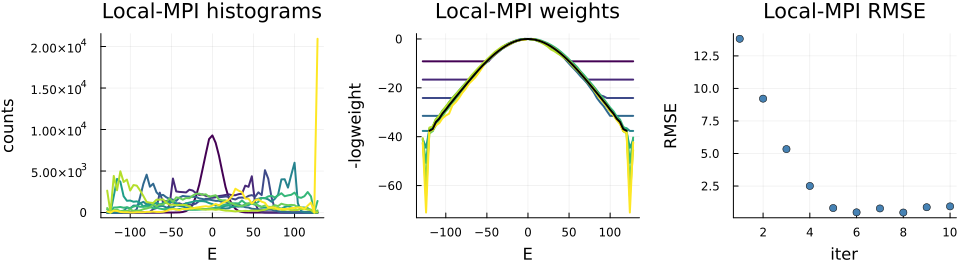

Final Local-MPI RMSE (exact) = 0.9385


In [10]:
# Notebook-local MPI-style: RMSE + plot (vs exact Beale logDOS)
rmse_localmpi = plot_from_hist_lw(localmpi_hists, localmpi_lws; title_prefix="Local-MPI ")
println("Final Local-MPI RMSE (exact) = ", round(last(rmse_localmpi), digits=4))